# Симуляция A/B-теста

**Цель:** проверить, как изменение цены (±5%) влияет на выручку и средний чек.

**Почему симуляция:** данные исторические, реальные изменения цены для клиентов невозможны. Мы создаём случайные группы и моделируем изменение цены.

**Гипотезы:**  
- H0: изменение цены не влияет на выручку  
- H1: изменение цены влияет выручку

**Метрики:** revenue_m, units_sold, средний чек

## 1. Загрузка данных и подключение библиотек

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

df = pd.read_csv('../data/flipkard_with_features.csv')
df.head()

,product_id,product_name,category,brand,seller,seller_city,price,discount_percent,final_price,rating,...,rating_segment,fast_delivery,long_warranty,heavy_product,returnable,high_rating,popular_product,trusted_seller,avg_revenue_by_category,avg_units_sold_by_brand
0,FKP0000001,Adidas Ultra 664,Toys,Adidas,MegaStore,Hyderabad,35547.34,15,30215.24,1.9,...,low,0,1,1,1,0,1,0,59.742742,2548.707820
1,FKP0000002,LG Series 124,Fashion,LG,ValueKart,Mumbai,30693.79,10,27624.41,3.2,...,mid,0,0,0,1,0,1,0,59.479754,2507.660804
2,FKP0000003,Redmi Model 35,Beauty,Redmi,SmartDeals,Ahmedabad,51214.50,40,30728.70,4.4,...,high,0,1,0,0,0,0,0,60.017435,2494.449813
3,FKP0000004,Sony Edition 769,Toys,Sony,UrbanRetails,Delhi,33168.49,30,23217.94,2.8,...,low,1,1,1,0,0,0,0,59.742742,2483.466616
4,FKP0000005,Boat Prime 291,Home & Kitchen,Boat,RetailHub,Pune,14181.34,0,14181.34,3.7,...,mid,0,0,0,1,0,1,1,59.731439,2528.777862


## 2. Выбор сегмента товаров
  
**Цель:** выбрать однородный сегмент товаров по цене, рейтингу, возвратной политике и надежности продавца, чтобы уменьшить влияние посторонних факторов

In [2]:
df_segment = df[
    (df['price_segment']=='mid') & 
    (df['rating_segment']=='high') &
    (df['returnable']==1) & 
    (df['trusted_seller']==1)
].copy()

df_segment.shape

(1419, 44)

## 3. Создание групп A/B

Случайное разделение позволяет избежать систематической ошибки. Для группы B повышаем цену на 5% и пересчитываем выручку.

In [3]:
np.random.seed(42)
df_segment['group'] = np.random.choice(['A', 'B'], size=len(df_segment))

#изменение цены для тестовой группы
df_segment['price_modified'] = df_segment['price']
df_segment.loc[df_segment['group']=='B', ['price_modified']] *= 1.05

#расчиатем выручку с учетом модифицированной цены
df_segment['revenue_modified_m'] = df_segment['price_modified'] * df_segment['units_sold'] / 1_000_000
df_segment['avg_order_modified'] = df_segment['revenue_modified_m'] * 1_000_000 / df_segment['units_sold']

## 4. Визуальный анализ
  
**Цель:** посмотреть предварительную разницу между группами и выявить выбросы

### 4.1 Выручка по группам

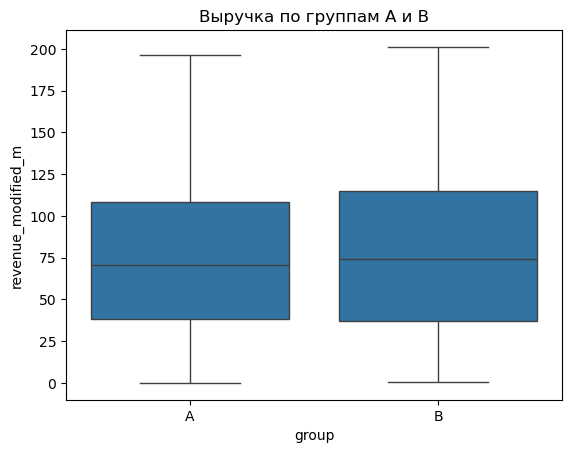

In [9]:
#Выручка
sns.boxplot(x='group', y='revenue_modified_m', data=df_segment)
plt.title('Выручка по группам A и B')
plt.savefig(f'../images/ab_test/revenue.png', dpi=300, bbox_inches='tight')
plt.show()

**Вывод**: Повышение цены на 5% для группы B не привело к заметному изменению выручки. На графике видно, что распределения выручки по группам практически совпадают, что предварительно подтверждает гипотезу H0 — изменение цены в этом диапазоне не сильно влияет на общую выручку.

### 4.2 Средний чек по группам (цена товара)

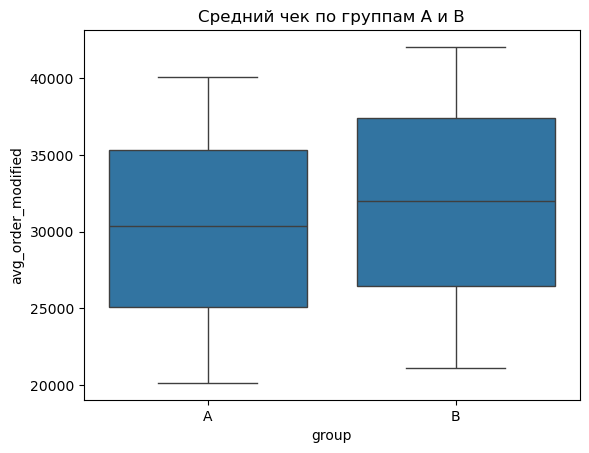

In [10]:
#Средний чек = цена товара 
sns.boxplot(x='group', y='avg_order_modified', data=df_segment)
plt.title('Средний чек по группам A и B')
plt.savefig(f'../images/ab_test/avg_order.png', dpi=300, bbox_inches='tight')
plt.show()

**Вывод:** Повышение цены на 5% у группы B привело к ожидаемому росту среднего чека всвязи с особенностями данных (цена = средний чек). Разница невелика, что указывает на умеренное влияние небольшой корректировки цены на итоговую сумму заказа. Случайное распределение товаров/клиентов также вносит небольшие колебания в распределение среднего чека.

### 4.3 Вывод

Небольшое повышение цены (+5%) в рамках выбранного сегмента товаров **увеличивает средний чек**, но **общая выручка остаётся почти на том же уровне**. Разброс результатов частично объясняется случайным распределением товаров и клиентов между группами, а снижение количества проданных единиц в данных не моделировалось. Эти результаты демонстрируют типичную ситуацию: небольшая корректировка цены влияет на средний чек, но её влияние на выручку может быть незначительным.

## 5. Статистический тест
  
**Цель:** провести t-тест и проверить гипотезу о влиянии изменения цены на выручку

In [6]:
rev_a = df_segment[df_segment['group']=='A']['revenue_modified_m']
rev_b = df_segment[df_segment['group']=='B']['revenue_modified_m']

stat, p_value = ttest_ind(rev_a, rev_b, equal_var=False)
print(f't-statistic = {stat:.3f}, p-value = {p_value:.3f}')
print(f'Разница средних выручек: {rev_b.mean() - rev_a.mean():.2f}')

t-statistic = -1.192, p-value = 0.233
Разница средних выручек: 3.00


**Вывод:** p-value = 0.233, что выше стандартного уровня значимости 0.05, поэтому мы не отвергаем нулевую гипотезу H0. Это означает, что статистически значимого влияния повышения цены на выручку выявлено не было. Разница средних выручек между группами мала и может объясняться случайным распределением товаров и клиентов. Другими словами, **небольшое повышение цены не приводит к заметному изменению общей выручки** в выбранном сегменте товаров.

## 6. Дополнительные метрики и углубленный анализ
  
**Цель:** понять, как изменение цены влияет на разные сегменты и товары

In [7]:
#средний чек по группам 
df_segment.groupby('group')['avg_order_modified'].mean()

group
A    30138.579280
B    31798.703011
Name: avg_order_modified, dtype: float64

**Вывод:** Средний чек выше в группе B из-за повышения цены на 5%; в данных он фактически равен цене товара.

In [8]:
#выручка по категориям 
df_segment.groupby(['category', 'group'])['revenue_modified_m'].mean()

category        group
Appliances      A        79.700021
                B        73.295720
Beauty          A        75.566732
                B        78.809351
Electronics     A        78.740574
                B        78.930012
Fashion         A        70.613529
                B        76.972720
Home & Kitchen  A        80.563199
                B        85.745858
Mobiles         A        69.766746
                B        83.702542
Sports          A        73.059062
                B        73.990674
Toys            A        75.501738
                B        72.395076
Name: revenue_modified_m, dtype: float64

**Вывод:** общая тенденция по всем категориям показывает умеренное влияние изменения цены на среднюю выручку, но сильнее проявляется случайный эффект распределения

# Общий вывод A/B-теста

- Разница средних выручек: 3.00
- p-value: 0.233
- Вывод: статистически значимого влияния повышения цены на 5% на выручку не выявлено (H₀ не отвергнута). Разброс результатов объясняется случайным распределением товаров и клиентов, а снижение количества проданных единиц в данных не моделировалось.
- Рекомендация: небольшие корректировки цен (±5%) можно проводить без риска значительного снижения выручки; повышение цены увеличивает средний чек, но общая выручка остаётся почти на том же уровне.